Cargando imagen histórica de entrenamiento...
✅ Imagen histórica procesada.

Buscando la imagen más reciente de GOES-19...
✅ Imagen reciente encontrada: ABI-L2-CMIPF/2025/266/19/OR_ABI-L2-CMIPF-M6C13_G19_s20252661950188_e20252661959507_c20252661959565.nc
✅ Imagen reciente procesada.


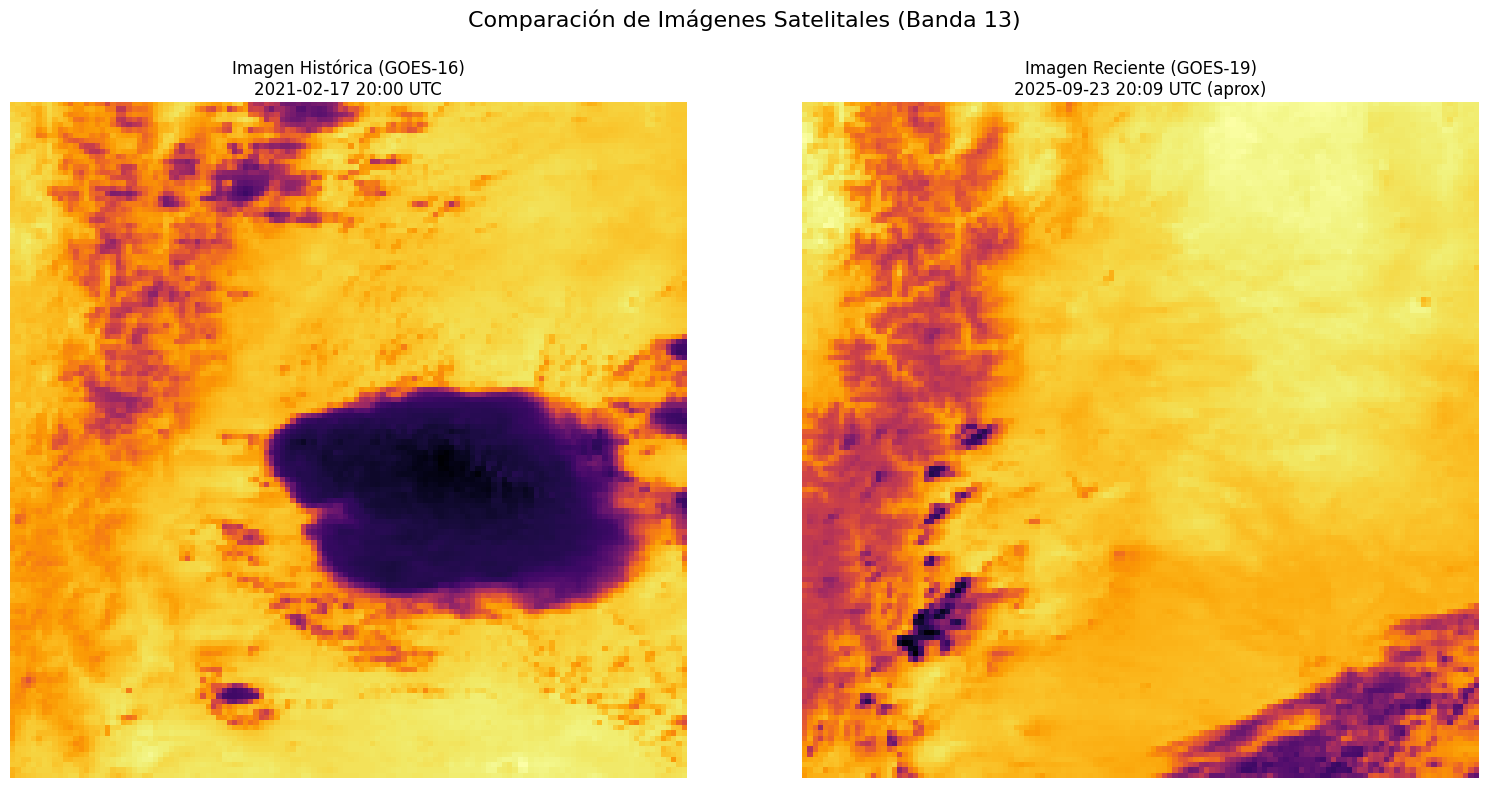

In [10]:
import xarray as xr
import matplotlib.pyplot as plt
import os
from pyproj import Proj
import boto3
from botocore import UNSIGNED
from botocore.config import Config
from datetime import datetime, timedelta, timezone
import numpy as np
import cv2

# --- 1. Función de Procesamiento (la que ya conocemos) ---
def procesar_y_recortar_imagen(ruta_archivo):
    """Abre un archivo .nc, lo recorta a Mendoza y lo devuelve."""
    IMG_SIZE = 128 # Aumentamos un poco la resolución para la visualización
    ds = xr.open_dataset(ruta_archivo)
    proj_info = ds.goes_imager_projection
    h_sat, lon_cen = proj_info.perspective_point_height, proj_info.longitude_of_projection_origin
    p = Proj(proj='geos', h=h_sat, lon_0=lon_cen)
    x1, y1 = p(-70.5, -37.5); x2, y2 = p(-66.5, -32.0)
    ds['x'] = ds['x'] * h_sat; ds['y'] = ds['y'] * h_sat
    recorte = ds.sel(x=slice(x1, x2), y=slice(y2, y1))['CMI'].values
    return cv2.resize(recorte, (IMG_SIZE, IMG_SIZE))

# --- 2. Cargar la Imagen Histórica ---
print("Cargando imagen histórica de entrenamiento...")
ruta_historica = "C:/Repositorios_Locales/Proyectos_Personales/Nimbus_AI/data/raw/imagenes_satelitales/2021-02-17_granizo/2021-02-17_2100_UTC_C13.nc"
try:
    imagen_historica = procesar_y_recortar_imagen(ruta_historica)
    print("✅ Imagen histórica procesada.")
except Exception as e:
    print(f"❌ No se pudo cargar la imagen histórica: {e}")
    imagen_historica = np.zeros((128, 128))

# --- 3. Descargar y Procesar la Imagen Reciente de GOES-19 ---
print("\nBuscando la imagen más reciente de GOES-19...")
imagen_reciente = np.zeros((128, 128)) # Creamos una imagen negra por defecto
try:
    s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    now_utc = datetime.now(timezone.utc)
    key_archivo_reciente = None
    
    for i in range(12): # Buscamos en las últimas 12 horas
        hora_a_buscar = now_utc - timedelta(hours=i)
        prefix = f"ABI-L2-CMIPF/{hora_a_buscar.year}/{hora_a_buscar.timetuple().tm_yday:03d}/{hora_a_buscar.hour:02d}/"
        response = s3.list_objects_v2(Bucket='noaa-goes19', Prefix=prefix)
        if 'Contents' in response:
            for file in reversed(response['Contents']):
                if 'C13' in file['Key']:
                    key_archivo_reciente = file['Key']
                    break
        if key_archivo_reciente:
            break
            
    if key_archivo_reciente:
        print(f"✅ Imagen reciente encontrada: {key_archivo_reciente}")
        nombre_archivo_temp = "temp_goes19.nc"
        s3.download_file('noaa-goes19', key_archivo_reciente, nombre_archivo_temp)
        imagen_reciente = procesar_y_recortar_imagen(nombre_archivo_temp)
        print("✅ Imagen reciente procesada.")
    else:
        print("❌ No se encontraron imágenes recientes de GOES-19.")
except Exception as e:
    print(f"❌ Error al obtener la imagen reciente: {e}")

# --- 4. Crear la Visualización Comparativa ---
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Comparación de Imágenes Satelitales (Banda 13)', fontsize=16)

# Imagen Histórica
axes[0].imshow(imagen_historica, cmap='inferno')
axes[0].set_title('Imagen Histórica (GOES-16)\n2021-02-17 20:00 UTC')
axes[0].axis('off')

# Imagen Reciente
axes[1].imshow(imagen_reciente, cmap='inferno')
axes[1].set_title(f'Imagen Reciente (GOES-19)\n{now_utc.strftime("%Y-%m-%d %H:%M")} UTC (aprox)')
axes[1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()